<a href="https://colab.research.google.com/github/v-patel18/Data-Mining_Midterm-Projects/blob/master/Titanic_Survivors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#ignore warnings
import sys
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

from google.colab import files
uploaded = files.upload()

-------------------------


In [0]:
#Create a dataframe from the csv files
train = pd.read_csv('train_titanic.csv')
test = pd.read_csv('test_titanic.csv')

#Save necessary info about the data
num_train = train.shape[0]
y_train = train['Survived'].values
pass_ID = test['PassengerId']

#Concatenate train and test
all_data = pd.concat((train,test))

#Look at the train file
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Data Visualization and Exploration**

In [0]:
#Find out how many null values exist
print(all_data.isnull().sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


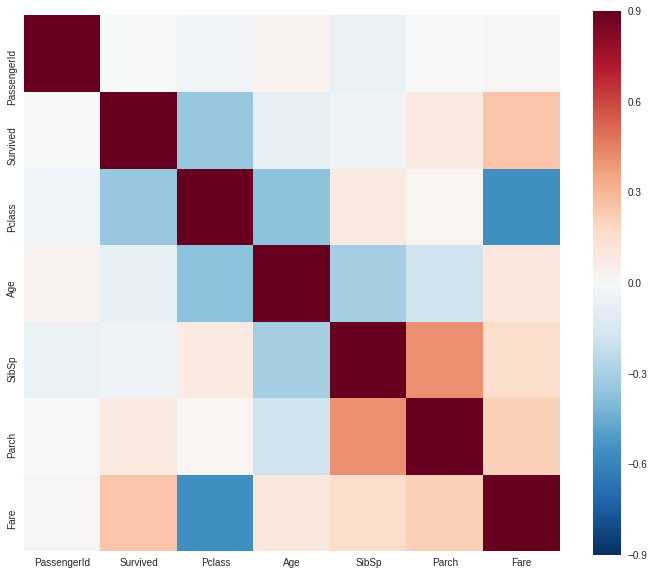

In [0]:
#Generate a correlation matrix for the train dataset
corrmat = train.corr()
f, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(corrmat, vmax = .9, square = True)

0    549
1    342
Name: Survived, dtype: int64


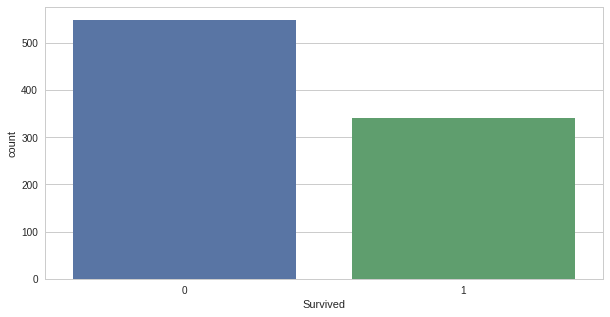

In [0]:
#Graph the survivors
fig = plt.figure(figsize = (10,5))
sns.countplot(x='Survived', data = train)
print(train['Survived'].value_counts())

The graph above shows that around 38% of the passengers in th train dataset survived, which is representative of the actual percentage of total passengers that survived (around 32%)

Text(0, 0.5, 'Percent Survived')

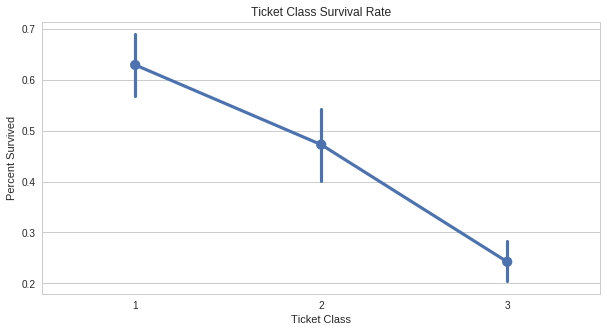

In [0]:
#PClass vs Survived
fig = plt.figure(figsize = (10,5))
ax1 = plt.subplot(1,1,1)
ax1 = sns.pointplot(x = 'Pclass', y = 'Survived', data = train)
ax1.set_title('Ticket Class Survival Rate')
ax1.set_xlabel('Ticket Class')
ax1.set_ylabel('Percent Survived')

The graph above shows that the better the ticket class, the higher the chances of survival

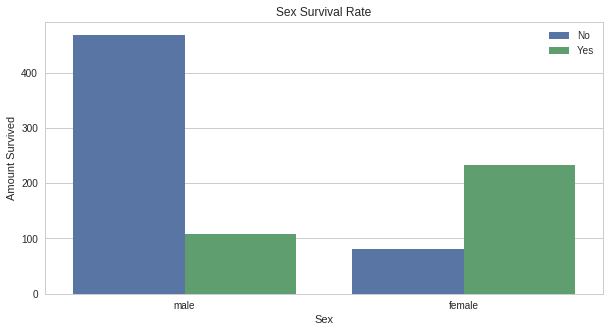

In [0]:
#Sex vs Survived
fig = plt.figure(figsize = (10,5))
ax1 = plt.subplot(1,1,1)
ax1 = sns.countplot(x = 'Sex', hue = 'Survived', data = train)
ax1.set_title('Sex Survival Rate')
ax1.set_xlabel('Sex')
ax1.set_ylabel('Amount Survived')
ax1.legend(['No','Yes'])

The graph above clearly shows that females had a significantly higher chance of survival

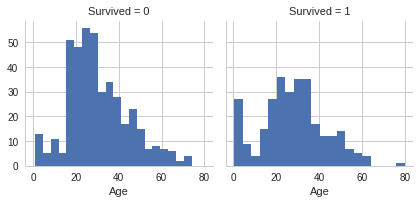

In [0]:
#Age vs Survival

g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Text(0.5, 1.0, 'Male')

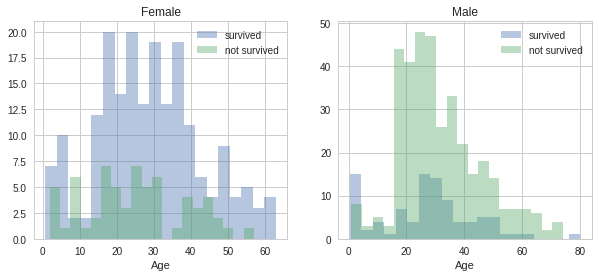

In [0]:
#Overlay of Age over Sex - dropped null values at the moment
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=20, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=20, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=20, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=20, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

The above plot shows women have significantly higher chances of survival across every age group. Also, the survival rate peaks around the age of 20-40 for both age groups

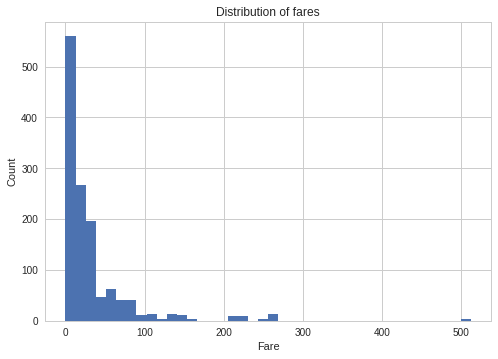

In [0]:
#Visualize the Fare data
plt.hist(all_data['Fare'], bins=40)
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Distribution of fares')
plt.show()

The above graph shows that fares are skewed to the left, which can be taken care of by binning the fares (done in the 'Handle Null Values' section).

**Feature Engineering**

In [0]:
#A passenger's name seems to be of little significance since most people are bound to have different names. However, names do include the titles,
#which can indicate the age group and gender - a combination of two of the features given, in essence

def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
      
titles = sorted(set([x for x in all_data['Name'].map(lambda x: get_title(x))]))
print(titles)

['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


In [0]:
#Combine similar titles
def set_title(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir', 'the Countess', 'Dona', 'Lady']:
        return 'Rare'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
      
all_data['Title'] = all_data['Name'].map(lambda x: get_title(x))
all_data['Title'] = all_data.apply(set_title, axis=1)

#Print the titles and their corresponding average survival rate
train_check = all_data[:num_train]
#train_check[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

**Handle Null Values**

In [0]:
#Since the titles can give us some idea about the age group, we can fill in the missing ages with the median of the age in the corresponding title group
all_data['Age'] = train_check.groupby('Title')['Age'].apply(lambda x: x.fillna(x.median()))

#Check for any remaining null values for 'Age'
print("Remaining null values in 'Age': {}".format(all_data['Age'].isnull().sum()))

Remaining null values in 'Age': 0


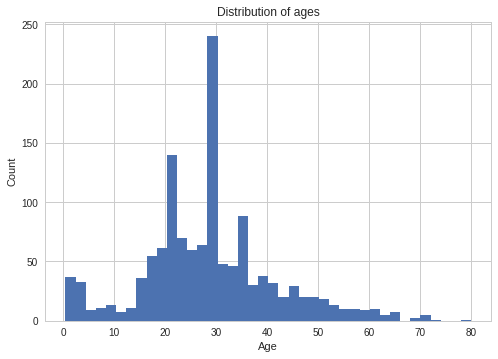

In [0]:
#Check for possible skewness in the 'Age' feature
plt.hist(all_data['Age'], bins=40)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of ages')
plt.show()

In [0]:
#Separate the ages into bins as a solution to the skew in the age distribution

bins = [0, 12, 21, 60, 90]
labels = ['Child', 'Adolescent', 'Adult', 'Elderly']
age_groups = pd.cut(all_data.Age, bins, labels = labels)
all_data['Age'] = age_groups

In [0]:
#Embarked has 2 null values
#Feature refers to port of embarkation - seems irrelevant to chances of survival (based on instinct) so can replace the null value with the mode

all_data['Embarked'] = all_data['Embarked'].fillna(train_check['Embarked'].mode()[0])

#Check for remaining null values in 'Embarked'
print("Remaining null values in 'Embarked:' {}".format(all_data['Embarked'].isnull().sum()))

Remaining null values in 'Embarked:' 0


In [0]:
#Fare has 1 null value - can fill it with the mean of the corresponding Pclass
all_data['Fare'].describe()
all_data['Fare'] = train_check.groupby('Pclass')['Fare'].apply(lambda x: x.fillna(x.mean()))

#Check for remaining null values in 'Fare'
print("Remaining null values in 'Fare:' {}".format(all_data['Fare'].isnull().sum()))

Remaining null values in 'Fare:' 0


In [0]:
#Cabin has 1000+ missing values - convert it to known and unknown for now (may delete the column entirely later)
def unknown_cabin(cabin):
    if(pd.isnull(cabin)):
        return 'U'
    else:
        return 'K'
      
all_data['Cabin'] = all_data['Cabin'].apply(lambda x:unknown_cabin(x))

#Check for remaining null values in 'Fare'
print("Remaining null values in 'Cabin:' {}".format(all_data['Cabin'].isnull().sum()))

Remaining null values in 'Cabin:' 0


In [0]:
#Find out which variables are non-numeric
non_numerics = all_data.select_dtypes(exclude = [np.number])
non_numerics.dtypes

Age         category
Cabin         object
Embarked      object
Name          object
Sex           object
Ticket        object
Title         object
dtype: object

In [0]:
#Convert values for 'Age' to numeric values

#Age
all_data['Age'] = all_data['Age'].replace(['Child', 'Adolescent', 'Adult', 'Elderly'], [0, 1, 2, 3])

In [0]:
#The Parch and SibSp could be used to generate a new feature - Family_Size

all_data['Family_Size'] = all_data['Parch'] + all_data['SibSp']
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,2,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,2,K,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,2,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,2,K,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,2,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


In [0]:
#People in a group/family tend to have similar survival rate - could be extracted by using a combination of various other features

# Extract last name
all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])

# Setting coin flip (e.g. random chance of surviving)
default_survival_chance = 0.5
all_data['Family_Survival'] = default_survival_chance

# Grouping data by last name and fare - looking for families
for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    # If not equal to 1, a family is found 
    # Then work out survival chance depending on whether or not that family member survived
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

# If not equal to 1, a group member is found
# Then work out survival chance depending on whether or not that group member survived
for _, grp_df in all_data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

Number of passengers with family survival information: 283


In [0]:
#Reset index
all_data = all_data.reset_index(drop=True)
all_data = all_data.drop('Survived', axis=1)

In [0]:
#Compute Fare/Passenger
train = all_data[:num_train]
test = all_data[num_train:]

trainTickets = train["Ticket"].value_counts()
testTickets = test["Ticket"].value_counts()
bothTickets = np.intersect1d(train["Ticket"].values, test["Ticket"].values)

for i in range(0, num_train):
    ticket = train.at[i,"Ticket"]
    if(ticket in bothTickets):
        train.at[i,"FarePerPass"]=train.at[i,"Fare"]/(trainTickets[ticket] + testTickets[ticket])
    else:
        train.at[i,"FarePerPass"]=train.at[i,"Fare"]/(trainTickets[ticket])
        
for i in range(num_train, num_train+test.shape[0]):
    ticket = test.at[i,"Ticket"]
    if(ticket in bothTickets):
        test.at[i,"FarePerPass"]=test.at[i,"Fare"]/(trainTickets[ticket] + testTickets[ticket])
    else:
        test.at[i,"FarePerPass"]=test.at[i,"Fare"]/(testTickets[ticket])

all_data = pd.concat((train,test)).reset_index(drop=True)

#Make sure it works:
train["FamilyName"]=train["Name"].map(lambda x: x.split(",")[0].strip())
print("Example of correction for large Pclass 3 Family")
train[train.FamilyName == "Panula"][["Pclass","Name","Ticket","Fare","FarePerPass"]]

Example of correction for large Pclass 3 Family


,Pclass,Name,Ticket,Fare,FarePerPass
50,3,"Panula, Master. Juha Niilo",3101295,39.6875,5.669643
164,3,"Panula, Master. Eino Viljami",3101295,39.6875,5.669643
266,3,"Panula, Mr. Ernesti Arvid",3101295,39.6875,5.669643
638,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",3101295,39.6875,5.669643
686,3,"Panula, Mr. Jaako Arnold",3101295,39.6875,5.669643
824,3,"Panula, Master. Urho Abraham",3101295,39.6875,5.669643


In [0]:
#As mentioned before, bin the fare data into 4 bins
all_data['Fare'] = pd.qcut(all_data['Fare'], 4)

#Convert bin ranges into numbers
lbl = LabelEncoder()
all_data['Fare'] = lbl.fit_transform(all_data['Fare'])

#Do the same for FarePerPass
all_data['FarePerPass'] = pd.qcut(all_data['FarePerPass'], 4)

#Convert bin ranges into numbers
lbl = LabelEncoder()
all_data['FarePerPass'] = lbl.fit_transform(all_data['FarePerPass'])

In [0]:
#Delete the features no necessary for modeling
all_data = all_data.drop(['Name', 'Ticket', 'PassengerId', 'Parch', 'SibSp', 'Last_Name'], axis = 1)

#Now that the unwanted variables have been removed, use one hot encoding (because order doesn't matter) to convert non-numeric data to numeric
all_data = pd.get_dummies(all_data)

all_data.shape

(1309, 18)

**Create the Model**

In [0]:
#Import necessary libraries

# Pipeline and machine learning algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Model fine-tuning and evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection


In [0]:
#Split the concatenated data set into train and test datasets
train = all_data[:num_train]
test = all_data[num_train:]

#save passenger ids from the train dataset
#PassID_train = train['PassengerId']

#Set up feature and target variables
X_test = test
X_train = train

#Scale data to support modeling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Age                0
Fare               0
Pclass             0
Family_Size        0
Family_Survival    0
FarePerPass        0
Cabin_K            0
Cabin_U            0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Sex_female         0
Sex_male           0
Title_Master       0
Title_Miss         0
Title_Mr           0
Title_Mrs          0
Title_Rare         0
dtype: int64

In [0]:
# Initiate 3 classifier models
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()

# Prepare lists
models = [log, xgb, gbc]         
scores = []

# Sequentially fit and cross validate all models
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores.append(acc.mean())

In [0]:
# View the cross validation score for each model, in decreasing order
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Gradient Boosting'],
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head(11)


,Model,Score
0,Gradient Boosting,0.844004
1,XGBoost,0.841744
2,Logistic Regression,0.840671


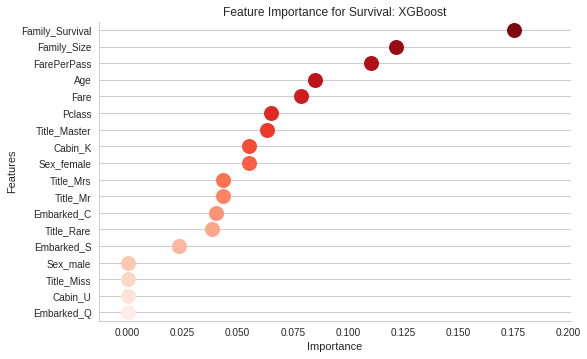

In [0]:
#Find out which features were given how much importance - XGBoost

def importance_plotting(data, x, y, palette, title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data, y_vars=y, x_vars=x, size=5, aspect=1.5)
    ft.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()

fi = {'Features':train.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

titles = ['Feature Importance for Survival: XGBoost']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

The "Embarked" features seem to be of little importance, as well as one of the "Cabin" features.

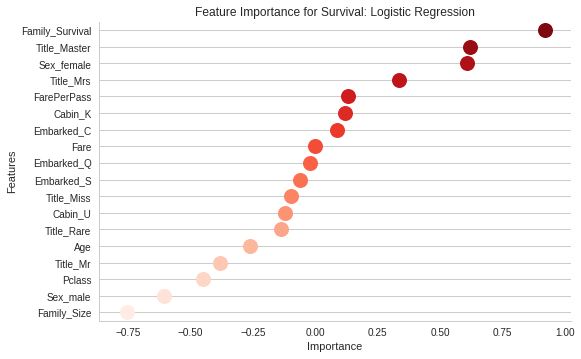

In [0]:
#Find out which features were given how much importance - Logistic Regression

fi = {'Features':train.columns.tolist(), 'Importance':np.transpose(log.coef_[0])}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

titles = ['Feature Importance for Survival: Logistic Regression']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

The features around the coefficient of 0.0 can be considered to be of little importance for the logistic regression model. These particularly include the "Embarked" features in this model, as well as both the "Cabin" features.

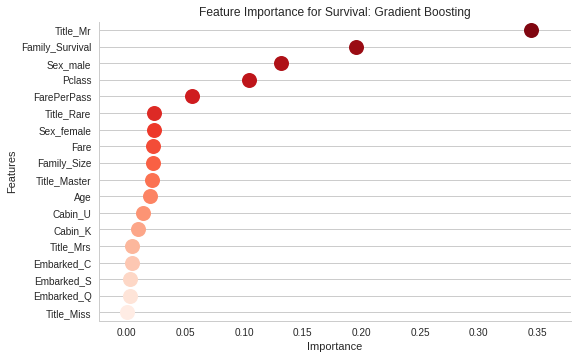

In [0]:
#Find out which features were given how much importance - GradientBoosting

fi = {'Features':train.columns.tolist(), 'Importance':gbc.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

titles = ['Feature Importance for Survival: Gradient Boosting']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

Once again, "Embarked" and "Cabin" features are once again on the lower end of the importance spectrum.

**Drop Features and Re-model**

In [0]:
#Remove Embarked_Q, Embarked_S, Embarked_C, Cabin_U, Cabin_K in efforts of decreasing noise
train = train.drop(['Embarked_Q', 'Embarked_S', 'Embarked_C', 'Cabin_U', 'Cabin_K'], axis=1)
test = test.drop(['Embarked_Q', 'Embarked_S', 'Embarked_C', 'Cabin_U', 'Cabin_K'], axis=1)

# Re-build model variables
X_train = train
X_test = test

# Transform
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
#Initiate model
gbc = GradientBoostingClassifier(random_state=1)
log = LogisticRegression()
xgb = XGBClassifier(random_state=1)

# Lists
models = [log, xgb, gbc]         
scores_v2 = []

# Fit & cross validate
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores_v2.append(acc.mean())
    
    
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Gradient Boosting'],
    'Original Score': scores,
    'Score with feature selection': scores_v2})

result_df = results.sort_values(by='Score with feature selection', ascending=False).reset_index(drop=True)
result_df.head()

,Model,Original Score,Score with feature selection
0,XGBoost,0.841744,0.847337
1,Logistic Regression,0.840671,0.845178
2,Gradient Boosting,0.844004,0.843979


In [0]:
#Use Soft Voting to generate the final model predictions
grid_soft = VotingClassifier(estimators = [('Logistic Regression', log), ('XGBoost', xgb), ('Gradient Boosting', gbc)], voting = 'soft')

#Cross Validate
grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv = 10)
grid_soft.fit(X_train, y_train)

#Final Predictions
predictions = grid_soft.predict(X_test)

submission = pd.concat([pd.DataFrame(pass_ID), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission.csv', header = True, index = False)


print("Soft voting on train set score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))

Soft voting on train set score mean: 85.96
Soft voting on test set score mean: 83.84


In [0]:
#Download the submission file
files.download('titanic_submission.csv')